To run the notebook on different machine, you need to adjust the following:
- Original preprocessed data directory
- Create 3 directories for ```nnUNet_raw```, ```nnUNet_preprocessed```, and ```nnUNet_results```
- Correct directory for nnunet raw in  ```create_nnunet_dataset_structure()``` function
- Correct directory in env variables
- Pick up the correct env variable export cell for your platform (Linux or Windows)

## Setup and Imports

In [ ]:
! pip install numpy nibabel matplotlib pandas torch scipy tqdm plotly optuna SimpleITK

In [ ]:
# must be done after installing pytorch
! pip install nnunetv2 


^C


INFO: pip is looking at multiple versions of unittest2 to determine which version is compatible with other requirements. This could take a while.
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
INFO: pip is still looking at multiple versions of unittest2 to determine which version is compatible with other requirements. This could take a while.
  Using cached charset_normalizer-3.4.3-cp312-cp312-win_amd64.whl.metadata (37 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached platformdirs-4.3.8-py3-none-any.whl.metadata (12 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
INFO: This is 

ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python >=3.8,<3.12; 1.10.0rc1 Requires-Python >=3.8,<3.12; 1.10.0rc2 Requires-Python >=3.8,<3.12; 1.10.1 Requires-Python >=3.8,<3.12; 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requ

In [9]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

from scipy.ndimage import rotate
import optuna

from optuna.pruners import MedianPruner
from torch.cuda.amp import autocast, GradScaler

import SimpleITK as sitk

import subprocess

from tqdm import tqdm

import shutil
import json

## Dataset Import

In [10]:

images_dir = r"E:\AIMS_Data\normalized_T1_scans"
masks_dir = r"E:\AIMS_Data\resampled_1mm_Lesion_masks"


# print number of files in processed images and masks
print(f"Number of processed images: {len(os.listdir(images_dir))}")
print(f"Number of processed masks: {len(os.listdir(masks_dir))}")


Number of processed images: 548
Number of processed masks: 548


Loaded scan_0001:
Image shape: (256, 256, 256)
Mask shape: (256, 256, 256)


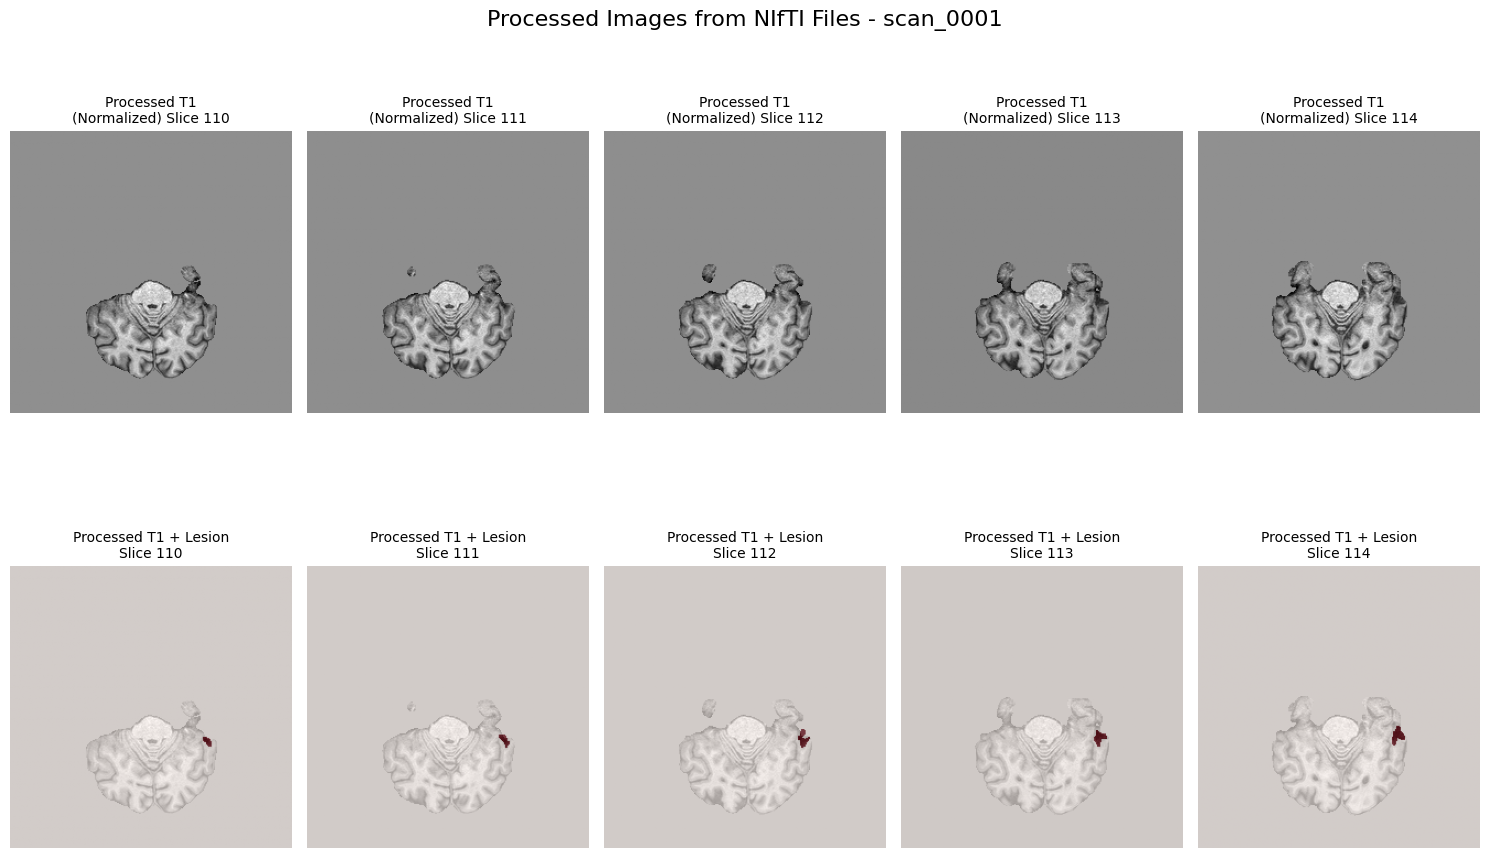


=== Statistics from NIfTI Files for scan_0001 ===
Processed T1 Image (from NIfTI file):
  Mean: -0.000000
  Std: 1.000000
  Min: -2.7810
  Max: 3.9446
  Shape: (256, 256, 256)

Lesion Mask (from NIfTI file):
  Lesion voxels: 2,150
  Total voxels: 16,777,216
  Lesion percentage: 0.0128%
  Shape: (256, 256, 256)


In [11]:
# Define scan parameters
scan_id = 'scan_0001'
start_slice = 110
num_slices = 5

# Load the .nii.gz files
image_path = os.path.join(images_dir, f"{scan_id}_T1_normalized.nii.gz")
mask_path = os.path.join(masks_dir, f"{scan_id}_Lesion_resampled_1mm.nii.gz")

# Load image and mask using nibabel
image_nii = nib.load(image_path)
mask_nii = nib.load(mask_path)

image_array = image_nii.get_fdata().astype(np.float32)
mask_array = mask_nii.get_fdata().astype(np.uint8)

print(f"Loaded {scan_id}:")
print(f"Image shape: {image_array.shape}")
print(f"Mask shape: {mask_array.shape}")

# Create visualization
fig, axes = plt.subplots(2, num_slices, figsize=(num_slices * 3, 10))

# Ensure axes is 2D even for single slice
if num_slices == 1:
    axes = axes.reshape(-1, 1)

for i in range(num_slices):
    slice_idx = start_slice + i

    # Check if slice index is valid
    if slice_idx >= image_array.shape[2]:
        print(f"⚠️ Slice {slice_idx} is out of bounds (max: {image_array.shape[2]-1}), skipping...")
        continue

    # Extract slices (transpose for proper orientation)
    image_slice = image_array[:, :, slice_idx].T
    mask_slice = mask_array[:, :, slice_idx].T

    # Row 1: Processed T1 image only
    axes[0, i].imshow(image_slice, cmap='gray', origin='lower')
    axes[0, i].set_title(f'Processed T1\n(Normalized) Slice {slice_idx}', fontsize=10)
    axes[0, i].axis('off')

    # Row 2: Processed T1 + Lesion overlay
    axes[1, i].imshow(image_slice, cmap='gray', origin='lower')
    if np.any(mask_slice > 0):  # Only overlay if there are lesions in this slice
        axes[1, i].imshow(mask_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[1, i].set_title(f'Processed T1 + Lesion\nSlice {slice_idx}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle(f'Processed Images from NIfTI Files - {scan_id}', fontsize=16, y=0.98)
plt.show()

# Print intensity statistics
print(f"\n=== Statistics from NIfTI Files for {scan_id} ===")

# Image stats (brain voxels only)
brain_mask = image_array != 0  # Background is 0 after normalization
brain_voxels = image_array[brain_mask]

print("Processed T1 Image (from NIfTI file):")
print(f"  Mean: {np.mean(brain_voxels):.6f}")
print(f"  Std: {np.std(brain_voxels):.6f}")
print(f"  Min: {np.min(brain_voxels):.4f}")
print(f"  Max: {np.max(brain_voxels):.4f}")
print(f"  Shape: {image_array.shape}")

# Lesion statistics
lesion_voxels = np.count_nonzero(mask_array)
total_voxels = mask_array.size
lesion_percentage = (lesion_voxels / total_voxels) * 100

print(f"\nLesion Mask (from NIfTI file):")
print(f"  Lesion voxels: {lesion_voxels:,}")
print(f"  Total voxels: {total_voxels:,}")
print(f"  Lesion percentage: {lesion_percentage:.4f}%")
print(f"  Shape: {mask_array.shape}")

# If you have metadata, you can print it here (optional)
# print(f"\nMetadata Statistics:")
# print(f"  Brain voxels: ...")
# print(f"  Brain mean: ...")
# print(f"  Brain std: ...")
# print(f"

### Verify the mask values are limited to 0 and 1

In [12]:
for fname in os.listdir(masks_dir):
    if fname.endswith("_Lesion_resampled_1mm.nii.gz"):
        mask_path = os.path.join(masks_dir, fname)
        mask_array = nib.load(mask_path).get_fdata().astype(np.uint8)
        unique_vals = np.unique(mask_array)
        if np.any((unique_vals != 0) & (unique_vals != 1)):
            print(f"{fname}: {unique_vals}")

## nnUNet setup

### Dataset conversion for nnUNet compatibility

Create nnU-Net Dataset Structure

In [13]:
def create_nnunet_dataset_structure():
    """Create nnU-Net compatible dataset structure"""
    
    # Set your nnUNet_raw path (adjust as needed)
    nnunet_raw = "E:/AIMS_Data/nnUNet_raw"  # or your path
    dataset_name = "Dataset600_TBILesion"  # Choose an unused ID
    
    dataset_path = os.path.join(nnunet_raw, dataset_name)
    
    # Create directories
    os.makedirs(os.path.join(dataset_path, "imagesTr"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "labelsTr"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "imagesTs"), exist_ok=True)  # Optional for test data
    
    return dataset_path

In [14]:
# dataset_path = create_nnunet_dataset_structure()
# print(f"Created dataset structure at: {dataset_path}")

Convert Your .pt Files to nnU-Net Format

In [15]:
def convert_pt_to_nnunet_format(processed_data_dir, dataset_path, train_ratio=0.85):
    """Enhanced conversion that saves test labels separately for evaluation"""
    
    images_dir = os.path.join(processed_data_dir, "images")
    masks_dir = os.path.join(processed_data_dir, "masks")
    metadata_dir = os.path.join(processed_data_dir, "metadata")
    
    # Get all scan IDs
    image_files = [f for f in os.listdir(images_dir) if f.endswith('_image.pt')]
    scan_ids = [f.replace('_image.pt', '') for f in image_files]
    
    print(f"Found {len(scan_ids)} scans to convert")
    
    # Stratified split to ensure lesion cases in both train/test
    # Load metadata to check for lesions
    lesion_scans = []
    no_lesion_scans = []
    
    for scan_id in scan_ids:
        metadata_path = os.path.join(metadata_dir, f"{scan_id}_metadata.json")
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        if metadata['statistics']['has_lesion']:
            lesion_scans.append(scan_id)
        else:
            no_lesion_scans.append(scan_id)
    
    print(f"Lesion scans: {len(lesion_scans)}")
    print(f"No-lesion scans: {len(no_lesion_scans)}")
    
    # Stratified split
    n_train_lesion = int(len(lesion_scans) * train_ratio)
    n_train_no_lesion = int(len(no_lesion_scans) * train_ratio)
    
    train_ids = lesion_scans[:n_train_lesion] + no_lesion_scans[:n_train_no_lesion]
    test_ids = lesion_scans[n_train_lesion:] + no_lesion_scans[n_train_no_lesion:]
    
    print(f"Training scans: {len(train_ids)}")
    print(f"Test scans: {len(test_ids)}")
    
    # Create separate directory for test labels (for evaluation)
    test_labels_dir = os.path.join(dataset_path, "test_labels_for_evaluation")
    os.makedirs(test_labels_dir, exist_ok=True)
    
    converted_count = 0
    metadata_preserved = []
    
    for split, ids in [("Tr", train_ids), ("Ts", test_ids)]:
        for scan_id in ids:
            try:
                # Load data
                image_path = os.path.join(images_dir, f"{scan_id}_image.pt")
                mask_path = os.path.join(masks_dir, f"{scan_id}_mask.pt")
                metadata_path = os.path.join(metadata_dir, f"{scan_id}_metadata.json")
                
                image_data = torch.load(image_path, map_location='cpu')
                mask_data = torch.load(mask_path, map_location='cpu')
                
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                
                # Extract arrays
                image_array = image_data['image'].squeeze(0).numpy().astype(np.float32)
                mask_array = mask_data['mask'].squeeze(0).numpy().astype(np.uint8)

                unique_vals = np.unique(mask_array)
                if np.any((unique_vals != 0) & (unique_vals != 1)):
                    print(f"Warning: {scan_id} has unexpected mask values: {unique_vals}. Remapping all >1 to 1.")
                    mask_array[mask_array > 1] = 1
                
                # Create affine matrix
                if 'spacing' in metadata:
                    spacing = metadata['spacing']
                    affine = np.diag([spacing[0], spacing[1], spacing[2], 1.0])
                else:
                    affine = np.eye(4)
                
                # Create NIfTI images
                image_nii = nib.Nifti1Image(image_array, affine)
                mask_nii = nib.Nifti1Image(mask_array, affine)
                
                # Preserve some metadata in NIfTI header
                if 'statistics' in metadata:
                    stats = metadata['statistics']
                    description = f"Lesion:{stats.get('has_lesion', False)},LesionVox:{stats.get('lesion_voxels', 0)}"
                    image_nii.header['descrip'] = description.encode()[:79]
                
                # Save images
                image_filename = f"{scan_id}_0000.nii.gz"
                image_save_path = os.path.join(dataset_path, f"images{split}", image_filename)
                nib.save(image_nii, image_save_path)
                
                # Save masks
                mask_filename = f"{scan_id}.nii.gz"
                if split == "Tr":
                    # Training labels go to labelsTr (nnU-Net requirement)
                    mask_save_path = os.path.join(dataset_path, "labelsTr", mask_filename)
                    nib.save(mask_nii, mask_save_path)
                else:
                    # Test labels go to separate folder for evaluation
                    mask_save_path = os.path.join(test_labels_dir, mask_filename)
                    nib.save(mask_nii, mask_save_path)
                
                # Preserve metadata
                metadata_preserved.append({
                    'scan_id': scan_id,
                    'split': split,
                    'original_metadata': metadata,
                    'file_paths': {
                        'image': image_save_path,
                        'mask': mask_save_path
                    }
                })
                
                converted_count += 1
                
                if converted_count % 50 == 0:
                    print(f"Converted {converted_count} scans...")
                    
            except Exception as e:
                print(f"Error converting {scan_id}: {e}")
                continue
    
    # Save metadata
    metadata_file = os.path.join(dataset_path, "preserved_metadata.json")
    with open(metadata_file, 'w') as f:
        json.dump(metadata_preserved, f, indent=2)
    
    # Save test scan list for evaluation
    test_scans_file = os.path.join(dataset_path, "test_scan_ids.json")
    with open(test_scans_file, 'w') as f:
        json.dump(test_ids, f, indent=2)
    
    print(f"Successfully converted {converted_count} scans")
    print(f"Test labels saved to: {test_labels_dir}")
    print(f"Test scan IDs saved to: {test_scans_file}")
    print(f"Preserved metadata saved to: {metadata_file}")
    
    return len(train_ids), len(test_ids)

In [16]:
# # Convert your data
# n_train, n_test = convert_pt_to_nnunet_format(processed_data_dir, dataset_path)

Create dataset.json File

In [17]:
def create_dataset_json(dataset_path, num_training):
    """Create dataset.json file for nnU-Net"""
    
    dataset_json = {
        "channel_names": {
            "0": "T1"  # Your T1-weighted MRI scans
        },
        "labels": {
            "background": 0,
            "lesion": 1
        },
        "numTraining": num_training,
        "file_ending": ".nii.gz",
        "dataset_name": "TBI_Lesion_Segmentation",
        "reference": "AIMS TBI Challenge",
        "licence": "Your License",
        "description": "Traumatic Brain Injury Lesion Segmentation Dataset"
    }
    
    # Save dataset.json
    json_path = os.path.join(dataset_path, "dataset.json")
    with open(json_path, 'w') as f:
        json.dump(dataset_json, f, indent=2)
    
    print(f"Created dataset.json with {num_training} training cases")
    print(f"Saved to: {json_path}")

In [18]:
# create_dataset_json(dataset_path, n_train)

Verify Dataset Structure

In [19]:
def verify_dataset_structure(dataset_path):
    """Verify the dataset structure is correct"""
    
    print("Verifying dataset structure...")
    
    # Check folder structure
    required_folders = ["imagesTr", "labelsTr"]
    for folder in required_folders:
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.exists(folder_path):
            print(f"❌ Missing folder: {folder}")
            return False
        else:
            print(f"✅ Found folder: {folder}")
    
    # Check dataset.json
    json_path = os.path.join(dataset_path, "dataset.json")
    if not os.path.exists(json_path):
        print("❌ Missing dataset.json")
        return False
    else:
        print("✅ Found dataset.json")
    
    # Check file counts
    images_tr = len([f for f in os.listdir(os.path.join(dataset_path, "imagesTr")) if f.endswith('.nii.gz')])
    labels_tr = len([f for f in os.listdir(os.path.join(dataset_path, "labelsTr")) if f.endswith('.nii.gz')])
    
    print(f"Training images: {images_tr}")
    print(f"Training labels: {labels_tr}")
    
    if images_tr != labels_tr:
        print("❌ Mismatch between number of images and labels")
        return False
    
    # Check file naming convention
    sample_files = os.listdir(os.path.join(dataset_path, "imagesTr"))[:5]
    for file in sample_files:
        if not file.endswith('_0000.nii.gz'):
            print(f"❌ Incorrect naming: {file} (should end with _0000.nii.gz)")
            return False
    
    print("✅ Dataset structure verification passed!")
    return True



In [20]:
# verify_dataset_structure(dataset_path)

Complete Dataset Conversion

In [21]:
# Complete conversion script
def convert_tbi_dataset_to_nnunet():
    """Complete conversion from your .pt format to nnU-Net format"""
    
    
    # Step 1: Create dataset structure
    dataset_path = create_nnunet_dataset_structure()
    
    # Step 2: Convert data
    n_train, n_test = convert_pt_to_nnunet_format(processed_data_dir, dataset_path)
    
    # Step 3: Create dataset.json
    create_dataset_json(dataset_path, n_train)
    
    # Step 4: Verify structure
    if verify_dataset_structure(dataset_path):
        print("\n🎉 Dataset successfully converted to nnU-Net format!")
        print(f"Dataset location: {dataset_path}")
        print("\nNext steps:")
        print("1. Set your environment variables")
        print("2. Run: nnUNetv2_plan_and_preprocess -d 600 --verify_dataset_integrity")
        print("3. Run: nnUNetv2_train 600 3d_fullres 0 --npz")
    else:
        print("❌ Dataset conversion failed!")

# Run the conversion


In [22]:
convert_tbi_dataset_to_nnunet()

NameError: name 'processed_data_dir' is not defined

### env variable setup

For Linux

In [ ]:
# ! export nnUNet_raw="/media/fabian/nnUNet_raw"
# ! export nnUNet_preprocessed="/media/fabian/nnUNet_preprocessed"
# ! export nnUNet_results="/media/fabian/nnUNet_results"
# ! export nnUNet_n_proc_DA=12

For windows (PowerShell)

In [ ]:
os.environ['nnUNet_raw'] = "E:/AIMS_Data/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "E:/AIMS_Data/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "E:/AIMS_Data/nnUNet_results"
os.environ['nnUNet_n_proc_DA'] = "12"

In [ ]:
# Verify the environment variables are set
print("Environment variables set:")
print(f"nnUNet_raw: {os.environ.get('nnUNet_raw')}")
print(f"nnUNet_preprocessed: {os.environ.get('nnUNet_preprocessed')}")
print(f"nnUNet_results: {os.environ.get('nnUNet_results')}")
print(f"nnUNet_n_proc_DA: {os.environ.get('nnUNet_n_proc_DA')}")

### Model Training

In [ ]:
! nnUNetv2_plan_and_preprocess -d 600 --verify_dataset_integrity

In [ ]:
# Example for fold 0; repeat for folds 1–4
! nnUNetv2_train 600 3d_fullres 0 --npz

In [ ]:
! nnUNetv2_train 600 3d_fullres 1 --npz
! nnUNetv2_train 600 3d_fullres 2 --npz
! nnUNetv2_train 600 3d_fullres 3 --npz
! nnUNetv2_train 600 3d_fullres 4 --npz

In [ ]:
! nnUNetv2_export_model_to_zip --dataset 600 --config 3d_fullres
